In [1]:
!pip install -U \
  protobuf>=5.26.1 \
  transformers==4.45.2 \
  tokenizers>=0.20 \
  accelerate \
  sentencepiece \
  einops


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 6.33.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.3 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.3 which is incompatible.
grpcio-status 1.71

In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [53]:
import torch
from transformers import LlavaForConditionalGeneration, LlavaProcessor

model_id = "llava-hf/llava-1.5-7b-hf"

processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

model.eval()
print("✅ LLaVA loaded successfully on Kaggle")

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ LLaVA loaded successfully on Kaggle


In [55]:
import torch
from PIL import Image
from transformers import LlavaProcessor, LlavaForConditionalGeneration


In [56]:
demo_data = [
    {
        "image": "/kaggle/input/drill-image/000651.jpg",
        "conversations": [
            {"from": "human", "value": "handle of a power drill"}
        ]
    },
    {
        "image": "/kaggle/input/drill-image/000651.jpg",
        "conversations": [
            {"from": "human", "value": "grasp for drilling holes"}
        ]
    }
]

In [57]:
def run_demo(example, model, processor):
    """
    Runs a single ManipVQA-style demo example using LLaVA
    """
    # 1. Load image
    image = Image.open(example["image"]).convert("RGB")

    # 2. Extract the human question
    question = example["conversations"][0]["value"]

    # 3. Build ManipVQA-style prompt
    prompt = f"""
USER: <image>
Please provide bounding box coordinates of the {question}.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
"""

    # 4. Convert to model inputs
    inputs = processor(
        text=prompt,
        images=image,
        return_tensors="pt"
    ).to("cuda")

    # 5. Run inference
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=80,
            do_sample=False
        )

    # 6. Decode output
    response = processor.decode(outputs[0], skip_special_tokens=True)

    return response


In [58]:
for i, example in enumerate(demo_data):
    print(f"\n--- Demo {i+1} ---")
    output = run_demo(example, model, processor)
    print(output)



--- Demo 1 ---


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



USER:  
Please provide bounding box coordinates of the handle of a power drill.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
[0.0, 0.39, 0.28, 0.69]

--- Demo 2 ---

USER:  
Please provide bounding box coordinates of the grasp for drilling holes.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
[0.0, 0.36, 0.5, 0.71]


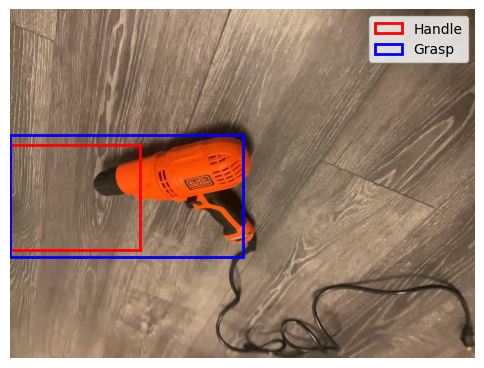

In [63]:
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open("/kaggle/input/drill-image/000651.jpg").convert("RGB")

bbox_handle = [0.0, 0.39, 0.28, 0.69]
bbox_grasp  = [0.0, 0.36, 0.5, 0.71]

def draw(image, bbox, color, label):
    w, h = image.size
    x1, y1, x2, y2 = bbox
    x1, y1 = int(x1*w), int(y1*h)
    x2, y2 = int(x2*w), int(y2*h)

    plt.gca().add_patch(
        plt.Rectangle(
            (x1, y1),
            x2-x1,
            y2-y1,
            fill=False,
            edgecolor=color,
            linewidth=2,
            label=label
        )
    )

plt.figure(figsize=(6,6))
plt.imshow(image)

draw(image, bbox_handle, "red", "Handle")
draw(image, bbox_grasp, "blue", "Grasp")

plt.legend()
plt.axis("off")
plt.show()


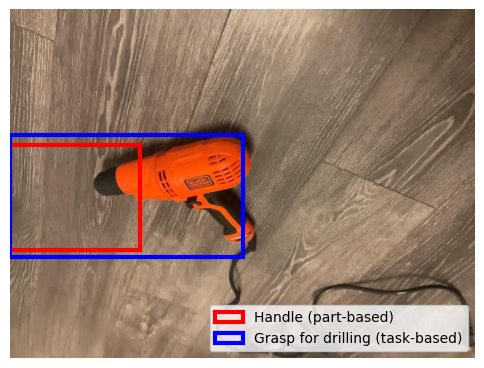

In [64]:
import matplotlib.pyplot as plt
from PIL import Image

# Load image
image = Image.open("/kaggle/input/drill-image/000651.jpg").convert("RGB")

# Model outputs
bbox_handle = [0.0, 0.39, 0.28, 0.69]
bbox_grasp  = [0.0, 0.36, 0.50, 0.71]

def draw_bbox(bbox, color, label):
    w, h = image.size
    x1, y1, x2, y2 = bbox
    x1, y1 = int(x1*w), int(y1*h)
    x2, y2 = int(x2*w), int(y2*h)

    plt.gca().add_patch(
        plt.Rectangle(
            (x1, y1),
            x2-x1,
            y2-y1,
            fill=False,
            edgecolor=color,
            linewidth=3,
            label=label
        )
    )

plt.figure(figsize=(6,6))
plt.imshow(image)

draw_bbox(bbox_handle, "red", "Handle (part-based)")
draw_bbox(bbox_grasp, "blue", "Grasp for drilling (task-based)")

plt.legend(loc="lower right")
plt.axis("off")
plt.show()
